In [1]:
from pathlib import Path
import numpy as np
from tifffile import imwrite
from caiman.utils.visualization import view_quilt
import utils as utl



# Convert suite2p output

Here we
1. Convert the motion-corrected suite2p `data.bin` file to a `data.tif` file.
2. Calculate the mean image for plotting.

In [2]:
# load data.bin and write as tiff file
p_root = Path(r"C:\temp\A214-20221214-02_data\suite2p\plane0")
p_tif = p_root / "data.tif"

data = utl.load_bin(p_root)
if not p_tif.is_file():
    imwrite(p_tif, data)

# mean image for visualization
img_mean = np.mean(data, axis=0)

# Caiman parameters

We are setting the parameters for the CNMF algorithm (motion-correction parameters are commented out).

Investigate the output of `view_quilt` to choose
- patch size `rf`
- overlap `stride_cnmf`
- number of components per patch `K`

See [Caiman demo notebook](https://github.com/flatironinstitute/CaImAn/blob/main/demos/notebooks/demo_pipeline.ipynb)
for more information.

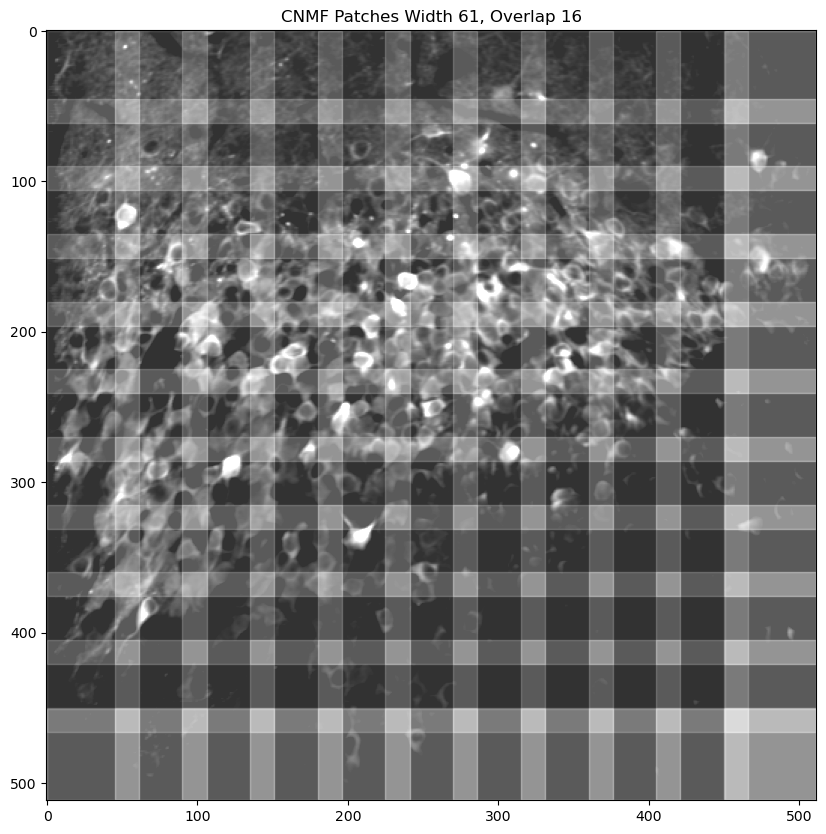

In [3]:
# general dataset-dependent parameters
fr = 30                     # imaging rate in frames per second
decay_time = 0.4            # length of a typical transient in seconds
dxy = (2., 2.)              # spatial resolution in x and y in (um per pixel)

# # motion correction parameters
# strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
# overlaps = (24, 24)         # overlap between patches (width of patch = strides+overlaps)
# max_shifts = (6,6)          # maximum allowed rigid shifts (in pixels)
# max_deviation_rigid = 3     # maximum shifts deviation allowed for patch with respect to rigid shifts
# pw_rigid = True             # flag for performing non-rigid motion correction

# CNMF parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system (set p=2 if there is visible rise time in data)
gnb = 2                     # number of global background components (set to 1 or 2)
merge_thr = 0.85            # merging threshold, max correlation allowed
bas_nonneg = True           # enforce nonnegativity constraint on calcium traces (technically on baseline)
rf = 30 # default: 15                     # half-size of the patches in pixels (patch width is rf*2 + 1)
stride_cnmf = 15 # default: 10             # amount of overlap between the patches in pixels (overlap is stride_cnmf+1) 
K = 4                       # number of components per patch
gSig = np.array([4, 4])     # expected half-width of neurons in pixels (Gaussian kernel standard deviation)
gSiz = 2*gSig + 1           # Gaussian kernel width and hight
method_init = 'greedy_roi'  # initialization method (if analyzing dendritic data see demo_dendritic.ipynb)
ssub = 1                    # spatial subsampling during initialization 
tsub = 1                    # temporal subsampling during intialization

# parameters for component evaluation
min_SNR = 2.0               # signal to noise ratio for accepting a component
rval_thr = 0.85             # space correlation threshold for accepting a component
cnn_thr = 0.99              # threshold for CNN based classifier
cnn_lowest = 0.1            # neurons with cnn probability lower than this value are rejected

parameter_dict = {
    # 'fnames': movie_path,
    'fr': fr,
    'dxy': dxy,
    'decay_time': decay_time,
    # 'strides': strides,
    # 'overlaps': overlaps,
    # 'max_shifts': max_shifts,
    # 'max_deviation_rigid': max_deviation_rigid,
    # 'pw_rigid': pw_rigid,
    'p': p,
    'nb': gnb,
    'rf': rf,
    'K': K, 
    'gSig': gSig,
    'gSiz': gSiz,
    'stride': stride_cnmf,
    'method_init': method_init,
    'rolling_sum': True,
    'only_init': True,
    'ssub': ssub,
    'tsub': tsub,
    'merge_thr': merge_thr, 
    'bas_nonneg': bas_nonneg,
    'min_SNR': min_SNR,
    'rval_thr': rval_thr,
    'use_cnn': True,
    'min_cnn_thr': cnn_thr,
    'cnn_lowest': cnn_lowest
                  }

# investigate CNMF patches
cnmf_patch_width = rf*2 + 1
cnmf_patch_overlap = stride_cnmf + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap

patch_ax = view_quilt(img_mean, 
                      cnmf_patch_stride, 
                      cnmf_patch_overlap, 
                      vmin=np.percentile(np.ravel(img_mean),50), 
                      vmax=np.percentile(np.ravel(img_mean),99.5),
                      figsize=(10,10));
patch_ax.set_title(f'CNMF Patches Width {cnmf_patch_width}, Overlap {cnmf_patch_overlap}');

# Run parameter search for Caiman

First, we are creating a batch file that stores the parameter combinations we want to screen.

Then, we loop over each parameter set and run CNMF.

Visualization of the results is done in a separate notebook.

In [4]:
# CAREFUL: this will delete the batch file if it exists

df = utl.create_batch(p_root)

params_mesmerize = {
    'main': parameter_dict,
    'refit': True, # If `True`, run a second iteration of CNMF
    }

for k in [10, 12]:
    for g in [3, 4]:
        gSig = np.array([g, g])
        gSiz = 2*gSig + 1
        for m in [0.8, .85]:
            params_mesmerize['main']['K'] = k
            params_mesmerize['main']['gSig'] = gSig
            params_mesmerize['main']['gSiz'] = gSiz
            params_mesmerize['main']['merge_thr'] = m

            # add a batch item
            df.caiman.add_item(
                algo='cnmf', # algo is cnmf
                input_movie_path=p_root / "data.tif", 
                params=params_mesmerize,
                item_name='test', # use the same item name
            )
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,7dd4ab90-9a21-4ad8-bc3d-57c48648d568
1,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,c699119d-1b14-4dac-8e73-5690306b0eda
2,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,7d406b9d-bf7c-4d01-aebf-21b233317c4d
3,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,75c0c6aa-e058-41d9-ba70-a6f8dddf81b5
4,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,64906d79-fb75-49b5-8ef0-7375549e433f
5,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,443ff047-854a-4729-b5e3-beb2d9c916f3
6,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,f283200a-5436-43af-a47c-8aad99c22032
7,cnmf,test,data.tif,"{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...",None,2024-02-09T16:29:22,None,None,None,adcacddf-ce02-47dc-9267-8f27782268af


In [5]:
utl.run_mesmerize(df)

Running 7dd4ab90-9a21-4ad8-bc3d-57c48648d568 with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             7dd4ab90-9a21-4ad8-bc3d-57c48648d568
Name: 0, dtype: object
With params:{'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_time': 0.4, 'p': 1, 'nb': 2, 'rf': 30, 'K': 12, 'gSig': array

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 7ms/step
Running c699119d-1b14-4dac-8e73-5690306b0eda with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                           

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 12ms/step
Running 7d406b9d-bf7c-4d01-aebf-21b233317c4d with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                          

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 8ms/step
Running 75c0c6aa-e058-41d9-ba70-a6f8dddf81b5 with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                           

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 10ms/step
Running 64906d79-fb75-49b5-8ef0-7375549e433f with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                          

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 9ms/step
Running 443ff047-854a-4729-b5e3-beb2d9c916f3 with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                           

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 8ms/step
Running f283200a-5436-43af-a47c-8aad99c22032 with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                           

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 8ms/step
Running adcacddf-ce02-47dc-9267-8f27782268af with local backend
************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                        test
input_movie_path                                             data.tif
params              {'main': {'fr': 30, 'dxy': (2.0, 2.0), 'decay_...
outputs                                                          None
added_time                                        2024-02-09T16:29:22
ran_time                                                         None
algo_duration                                                    None
comments                                           

making memmap


performing CNMF
fitting images
refitting
performing eval
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\spillern\caiman_data\model\cnn_model.json
31/31 [==============================] - 1s 8ms/step
